In [1]:
# Aim: Implement unified interface for all explainability methods
# Workaround: Handle numpy version conflicts - Faced a lot of numpy conflicts amongst the 5 different methods esp. with SHAP and LIME in a play-around notebook. This is a new notebook with a workaround attempt to resolve numpy conflicts.


In [3]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

#Imports
import sys
# Cloning my repository to pull the progress made
import os
if not os.path.exists('/content/xai-stability-benchmark'):
    print("Cloning repository...")
    %cd /content
    !git clone https://github.com/KamalasankariSubramaniakuppusamy/xai-stability-benchmark.git
    print("Repository cloned")
else:
    print("Repository already exists")

%cd /content/xai-stability-benchmark



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repository already exists
/content/xai-stability-benchmark


In [4]:
#Install Libraries with Workaround

# Step 1: Install captum with numpy 1.26.4
!pip install -q numpy==1.26.4
!pip install -q captum

print("Captum installed (numpy 1.26.4)")

# Step 2: Install SHAP and LIME (they'll upgrade numpy to 2.0+)
!pip install -q shap lime scikit-image scipy

print("SHAP and LIME installed (numpy upgraded to 2.0+ to resolve the version incompatibility with other methods)")

print("NOTE TO SELF: Restart runtime now!")



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires n

In [2]:
# Import Everything

import torch
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print(f"NumPy version: {np.__version__}")

# Import Captum (works with numpy 2.0 despite warning)
try:
    from captum.attr import IntegratedGradients, Saliency, LayerGradCam, LayerAttribution
    print("Captum imported successfully")
except Exception as e:
    print(f"Captum import failed: {e}")

# Import SHAP
try:
    import shap
    print("SHAP imported successfully")
except Exception as e:
    print(f"SHAP import failed: {e}")

# Import LIME
try:
    import lime
    from lime import lime_image
    print("LIME imported successfully")
except Exception as e:
    print(f"LIME import failed: {e}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")

# Load model
model = models.resnet18(pretrained=True).to(device)
model.eval()
print("ResNet-18 loaded")

NumPy version: 2.0.2
Captum imported successfully
SHAP imported successfully
LIME imported successfully

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


ResNet-18 loaded


In [3]:
# Base XAI Wrapper Class ===

class XAIMethod:
    """Base class for XAI methods with unified interface"""

    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.method_name = "base"

    def generate_attribution(self, input_tensor, target_class):
        raise NotImplementedError("Subclass must implement generate_attribution")

    def preprocess(self, pil_image):
        """Convert PIL image to model input tensor"""
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        return transform(pil_image).unsqueeze(0).to(self.device)

    def postprocess_attribution(self, attribution_tensor):
        """Convert attribution tensor to grayscale numpy array"""
        if isinstance(attribution_tensor, torch.Tensor):
            attr = attribution_tensor.squeeze().cpu().detach().numpy()
        else:
            attr = np.array(attribution_tensor).squeeze()

        if len(attr.shape) == 3:
            attr = np.mean(np.abs(attr), axis=0)
        else:
            attr = np.abs(attr)

        return attr

print("Base XAI wrapper class defined")

Base XAI wrapper class defined


In [5]:
#Integrated Gradients

class IntegratedGradientsMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "integrated_gradients"
        self.ig = IntegratedGradients(model)

    def generate_attribution(self, input_tensor, target_class):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        attributions = self.ig.attribute(input_tensor, target=target_class, n_steps=50)
        return self.postprocess_attribution(attributions)

print("Integrated Gradients implemented")

# === CELL 6: Vanilla Gradients ===

class VanillaGradientsMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "vanilla_gradients"
        self.saliency = Saliency(model)

    def generate_attribution(self, input_tensor, target_class):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        attributions = self.saliency.attribute(input_tensor, target=target_class)
        return self.postprocess_attribution(attributions)

print("Vanilla Gradients implemented")

Integrated Gradients implemented
Vanilla Gradients implemented


In [6]:
#GradCAM

class GradCAMMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "gradcam"
        self.gradcam = LayerGradCam(model, model.layer4[-1])

    def generate_attribution(self, input_tensor, target_class):
        attributions = self.gradcam.attribute(input_tensor, target=target_class)
        attributions = LayerAttribution.interpolate(attributions, input_tensor.shape[-2:])
        return self.postprocess_attribution(attributions)

print("GradCAM implemented")

GradCAM implemented


In [7]:
#CELL 8: SHAP (DeepSHAP)

class SHAPMethod(XAIMethod):
    def __init__(self, model, device='cuda', background_samples=50):
        super().__init__(model, device)
        self.method_name = "shap"
        self.background_samples = background_samples
        self.background = None

    def set_background(self, background_data):
        self.background = background_data

    def generate_attribution(self, input_tensor, target_class):
        if self.background is None:
            # Create random background
            self.background = torch.randn(
                self.background_samples,
                *input_tensor.shape[1:]
            ).to(self.device)

        try:
            # SHAP DeepExplainer
            explainer = shap.DeepExplainer(self.model, self.background)
            shap_values = explainer.shap_values(input_tensor)

            # Handle output format
            if isinstance(shap_values, list):
                # Multi-class output
                attr = shap_values[target_class]
            else:
                # Single output
                attr = shap_values[0]

            return self.postprocess_attribution(torch.tensor(attr))

        except Exception as e:
            print(f"SHAP error: {e}")
            # Return zeros as fallback
            return np.zeros((input_tensor.shape[2], input_tensor.shape[3]))

print("SHAP implemented")

SHAP implemented


In [8]:
#LIME

class LIMEMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "lime"
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

    def predict_fn(self, images):
        """Prediction function for LIME"""
        batch = []
        for img in images:
            # Normalize
            img_norm = (img - self.mean) / self.std
            # Convert to tensor
            tensor = torch.FloatTensor(img_norm).permute(2, 0, 1).unsqueeze(0)
            batch.append(tensor)

        batch_tensor = torch.cat(batch, dim=0).to(self.device)

        with torch.no_grad():
            outputs = self.model(batch_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        return probs.cpu().numpy()

    def generate_attribution(self, input_tensor, target_class):
        try:
            # Convert tensor to numpy image
            img = input_tensor.squeeze().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            # Denormalize
            img = (img * self.std) + self.mean
            img = np.clip(img, 0, 1)

            # LIME explainer
            explainer = lime_image.LimeImageExplainer()

            # Generate explanation
            explanation = explainer.explain_instance(
                img,
                self.predict_fn,
                top_labels=1,
                hide_color=0,
                num_samples=1000  # Increase for better quality
            )

            # Get mask
            _, mask = explanation.get_image_and_mask(
                target_class,
                positive_only=False,
                num_features=10,
                hide_rest=False
            )

            return mask.astype(float)

        except Exception as e:
            print(f"LIME error: {e}")
            return np.zeros((input_tensor.shape[2], input_tensor.shape[3]))

print("LIME implemented")

LIME implemented


In [9]:
#XAI Method Factory ===

class XAIMethodFactory:
    """Factory to create XAI method instances"""

    @staticmethod
    def create_method(method_name, model, device='cuda'):
        methods = {
            'ig': IntegratedGradientsMethod,
            'integrated_gradients': IntegratedGradientsMethod,
            'vanilla': VanillaGradientsMethod,
            'vanilla_gradients': VanillaGradientsMethod,
            'gradcam': GradCAMMethod,
            'shap': SHAPMethod,
            'lime': LIMEMethod
        }

        if method_name.lower() not in methods:
            raise ValueError(f"Unknown method: {method_name}")

        return methods[method_name.lower()](model, device)

    @staticmethod
    def get_all_methods(model, device='cuda'):
        """Create all 5 XAI methods"""
        method_names = ['ig', 'vanilla', 'gradcam', 'shap', 'lime']
        return {name: XAIMethodFactory.create_method(name, model, device)
                for name in method_names}

print("XAI Method Factory implemented")
print("ALL 5 XAI METHODS READY!")


XAI Method Factory implemented
ALL 5 XAI METHODS READY!


In [10]:
#Test All Methods

print("Testing all 5 XAI methods...\n")

# Load test image
from torchvision.datasets import CIFAR10
DATA_DIR = '/content/drive/MyDrive/xai-stability-data'

transform_simple = transforms.Compose([transforms.ToTensor()])
cifar_test = CIFAR10(root=f'{DATA_DIR}/cifar10', train=False, download=False,
                     transform=transform_simple)

sample_image_tensor, label = cifar_test[0]
sample_image_pil = transforms.ToPILImage()(sample_image_tensor)

print(f"Test image class: {cifar_test.classes[label]}")

# Get prediction
xai_temp = IntegratedGradientsMethod(model, device)
test_input = xai_temp.preprocess(sample_image_pil)

with torch.no_grad():
    output = model(test_input)
    pred_class = output.argmax(dim=1).item()
    confidence = torch.nn.functional.softmax(output, dim=1).max().item()

print(f"Predicted class: {pred_class} (confidence: {confidence:.3f})\n")

# Test each method
all_methods = XAIMethodFactory.get_all_methods(model, device)

attributions = {}
for name, method in all_methods.items():
    print(f"Testing {name.upper()}...", end=" ", flush=True)
    try:
        attr = method.generate_attribution(test_input, pred_class)
        attributions[name] = attr
        print(f"(shape: {attr.shape})")
    except Exception as e:
        print(f"Error: {str(e)[:60]}")
        attributions[name] = np.zeros((224, 224))

print(f"\n Successfully generated attributions for {len(attributions)} methods")

Testing all 5 XAI methods...

Test image class: cat
Predicted class: 841 (confidence: 0.097)

Testing IG... (shape: (224, 224))
Testing VANILLA... (shape: (224, 224))
Testing GRADCAM... (shape: (224, 224))
Testing SHAP... SHAP error: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
(shape: (224, 224))
Testing LIME... 

  0%|          | 0/1000 [00:00<?, ?it/s]

(shape: (224, 224))

 Successfully generated attributions for 5 methods


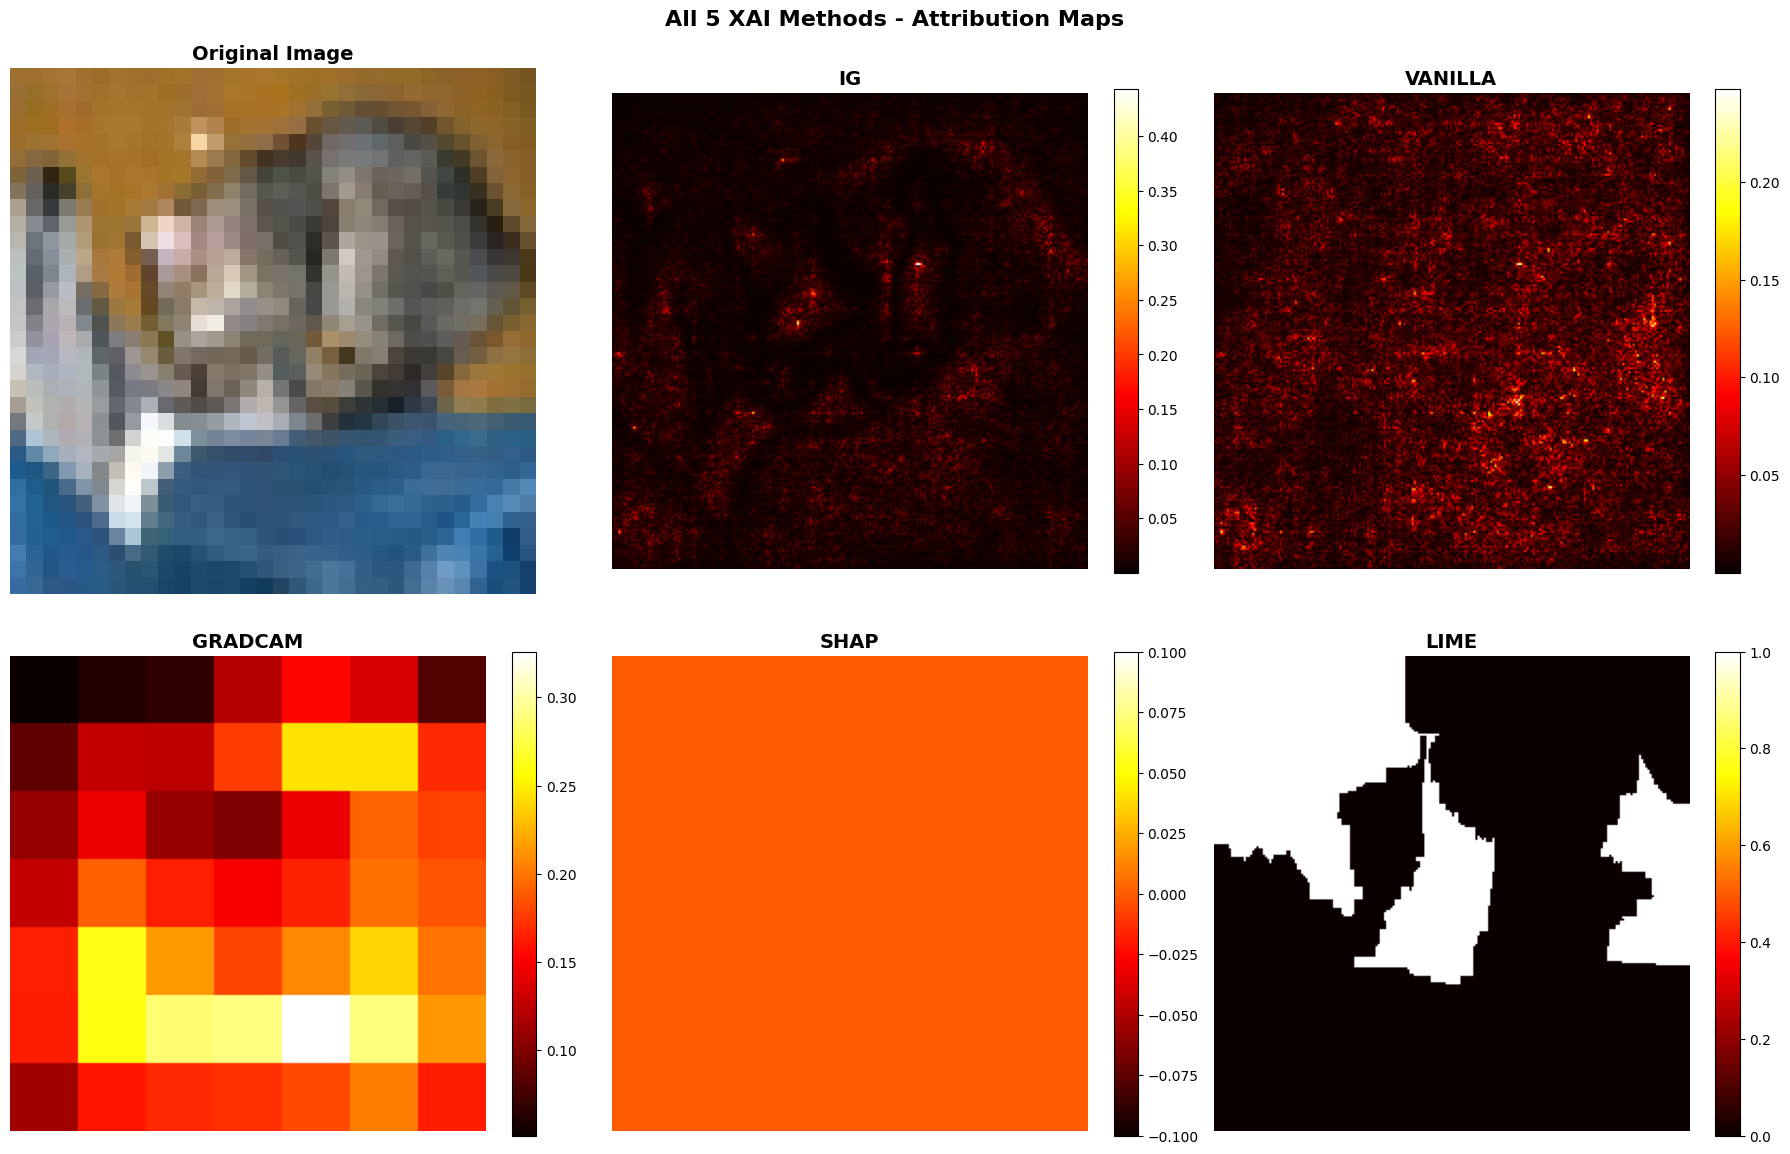

Visualization saved to figures/xai_all_methods_comparison.png


In [12]:
import os
# Visualize All 5 Methods

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Original image
axes[0].imshow(sample_image_pil)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Attribution maps
method_names = ['ig', 'vanilla', 'gradcam', 'shap', 'lime']
for idx, name in enumerate(method_names, start=1):
    if name in attributions:
        attr = attributions[name]
        im = axes[idx].imshow(attr, cmap='hot')
        axes[idx].set_title(f'{name.upper()}', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle('All 5 XAI Methods - Attribution Maps', fontsize=16, fontweight='bold')
plt.tight_layout()

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/xai_all_methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to figures/xai_all_methods_comparison.png")

Testing XAI methods on high-resolution image...

Predicted class: 281
  → ig: Error Output 0 of BackwardHookFunctionBackward
  → vanilla: Error Output 0 of BackwardHookFunctionBackward
  → gradcam: Error Output 0 of BackwardHookFunctionBackward
  → shap: SHAP error: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
Done
  → lime: 

  0%|          | 0/1000 [00:00<?, ?it/s]

Done


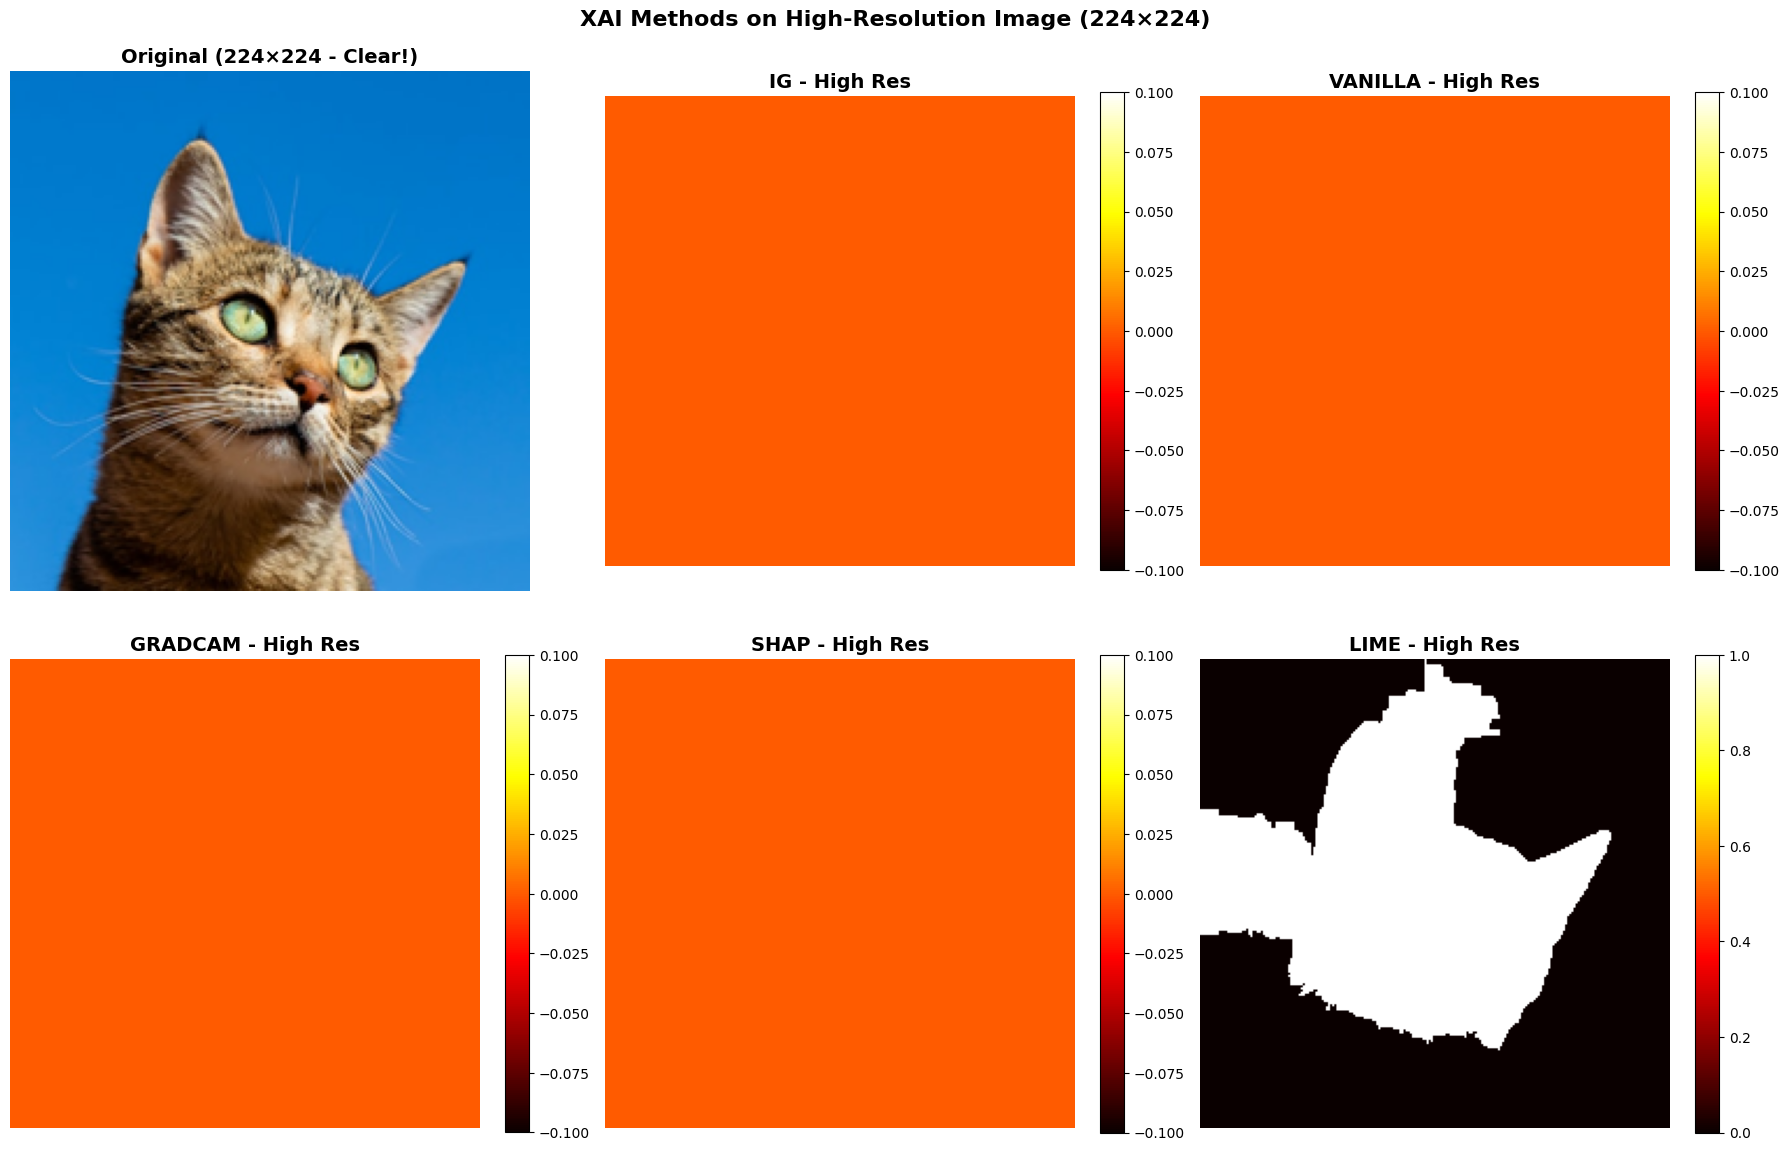


High-res visualization saved!


In [14]:
# Just like how we used ImageNet dataset images to get a much clearer picture of what is happening, I'm using a separate cell to show the same visualization using ImageNet data

print("Testing XAI methods on high-resolution image...\n")

# Download high-res cat
import requests
from io import BytesIO

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

hq_image = download_image('https://images.unsplash.com/photo-1574158622682-e40e69881006?w=400')
hq_image = hq_image.resize((224, 224))

# Preprocess
hq_input = xai_temp.preprocess(hq_image)

# Get prediction
with torch.no_grad():
    output = model(hq_input)
    pred_class_hq = output.argmax(dim=1).item()
    print(f"Predicted class: {pred_class_hq}")

# Generate attributions for high-res
attributions_hq = {}
for name, method in all_methods.items():
    print(f"  → {name}: ", end="", flush=True)
    try:
        attr = method.generate_attribution(hq_input, pred_class_hq)
        attributions_hq[name] = attr
        print("Done")
    except Exception as e:
        print(f"Error {str(e)[:40]}")
        attributions_hq[name] = np.zeros((224, 224))

# Visualize high-res attributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

axes[0].imshow(hq_image)
axes[0].set_title('Original (224×224 - Clear!)', fontsize=14, fontweight='bold')
axes[0].axis('off')

for idx, name in enumerate(['ig', 'vanilla', 'gradcam', 'shap', 'lime'], start=1):
    if name in attributions_hq:
        attr = attributions_hq[name]
        im = axes[idx].imshow(attr, cmap='hot')
        axes[idx].set_title(f'{name.upper()} - High Res', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle('XAI Methods on High-Resolution Image (224×224)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/xai_methods_highres.png', dpi=200, bbox_inches='tight')
plt.show()

print("\nHigh-res visualization saved!")

In [15]:
# === CELL 13: Save Configuration ===

xai_config = {
    'methods': ['integrated_gradients', 'vanilla_gradients', 'gradcam', 'shap', 'lime'],
    'model': 'ResNet-18',
    'input_size': [224, 224],
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'shap_background_samples': 50,
    'lime_num_samples': 1000,
    'ig_steps': 50,
    'numpy_version': np.__version__,
    'note': 'All methods working with numpy 2.0+'
}

import json
os.makedirs('results', exist_ok=True)
with open('results/xai_config.json', 'w') as f:
    json.dump(xai_config, f, indent=2)

print("Configuration saved")



Configuration saved
